In [136]:
from collections import defaultdict
import random

from tqdm.notebook import tqdm

import pandas as pd
from collections import Counter

from scipy import sparse
from scipy.sparse.linalg import svds
import numpy as np

from sklearn.metrics.pairwise import cosine_similarity

from nltk.tokenize import sent_tokenize, word_tokenize, regexp_tokenize

import glob
import re
import matplotlib.pyplot as plt

import math

In [2]:
english_books = glob.glob('english_books/*')

In [3]:
book_word_d = {}
all_book = ""
for b in books:
    book = b[14:]
    with open('english_books\\'+book,encoding="utf8") as fi:
        book_r = fi.read()
    start_b = re.search(r"\*\*\*[\w|\s]+[\;|\w]+[\w|\s]+\*\*\*",book_r)
    end = start_b.end()
    try_book = book_r[end:]
    end_b = re.search(r"\*\*\*[\w|\s]+[\;|\w]+[\w|\s]+\*\*\*",try_book)
    cut_off = end_b.start()
    complete_b = try_book[:cut_off]
    c_book = complete_b.replace('\n', ' ')
    book_name = book[:-4]
    book_word_d[book_name] = c_book
    all_book = all_book + c_book

NameError: name 'books' is not defined

In [30]:
book_r_words = [x.lower() for x in regexp_tokenize(all_book, '\w+')]
book_r_counter = Counter(book_r_words).most_common(200)

In [31]:
word_num = 1
for item in war_r_counter:
    print("rank {}: {} {}".format(word_num,item[1],item[0]))
    word_num = word_num + 1

NameError: name 'war_r_counter' is not defined

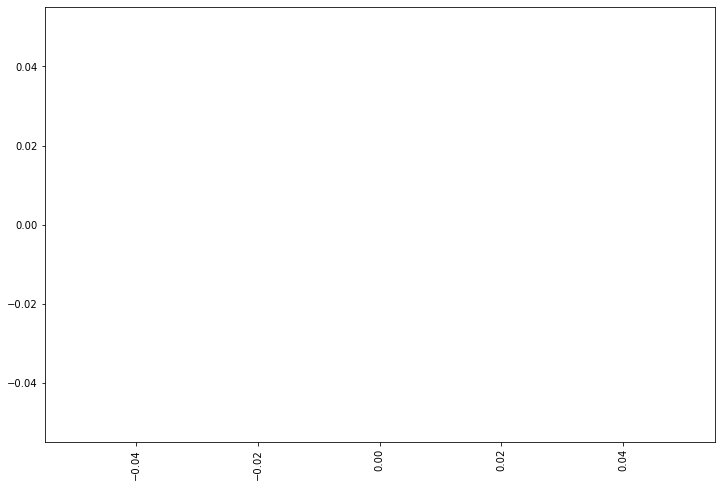

In [32]:
plt.rcParams["figure.figsize"] = [12, 8]
false_word = ['s','t','n']
ind = []
fre = []
fretwo = []
rnk = []
run = 1
for item in book_r_counter:
    if item[0] not in false_word:
        ind.append(item[0])
        fre.append(item[1])
        fretwo.append(math.log(item[1]))
        rnk.append(math.log(run))
        run = run + 1

#plt.bar(ind, fre, alpha = 1)
plt.xticks(rotation='vertical')
plt.plot(rnk, fretwo, alpha =  .75)

plt.yscale('linear')

plt.show()

In [33]:
column_name_list = ['book_name']
column_name_list.extend(list((range(1, 201))))
column_name_list = list((range(1, 201)))

In [49]:
log_name_list = []
for r in column_name_list:
    log_name_list.append(math.log(r))

In [50]:
word_df = pd.DataFrame(columns=column_name_list)

In [51]:
word_df.loc[0,:] = log_name_list

In [52]:
count = 0
book_index = []
for b in book_word_d:
    if count < 50:
        word_rank = 0 
        #print(b)
        false_word = ['s','t','n']
        ind = []
        fre = []
        fretwo = []
        run = 1
        book_token_words = [x.lower() for x in regexp_tokenize(book_word_d[b], '\w+')]
        if len(book_token_words) > 9999:
            book_index.append(b)
            book_token_counter = Counter(book_token_words).most_common(230)
            max_fre = 0
            #fretwo.append(b)
            for item in book_token_counter:
                if item[0] not in false_word:
                    if word_rank < 200:
                        ind.append(item[0])
                        fre.append(item[1])
                        fretwo.append(math.log(item[1]))
                        if (item[1]*run) > max_fre:
                            max_fre = item[1]*run
                        run = run + 1
                        word_rank = word_rank + 1
            #normlized_fre = [x / max_fre for x in fretwo]
            #word_df.iloc[count+1,0] = b
            word_df.loc[count+1,:] = fretwo
            count = count + 1
        word_df

In [53]:
word_df = word_df.apply(pd.to_numeric)

In [54]:
count = 0
for row in word_df.iterrows():
    if count != 0:
        theta = np.polyfit(word_df.loc[0,:], word_df.loc[count,:], 1)
        print("{} slope of {}".format(theta[0],book_index[count-1]))
    count = count + 1

In [55]:
def create_book_dictionary(book_folder_name):
    glob_name = book_folder_name + '/*'
    books_in_folder = glob.glob(glob_name)
    book_path = book_folder_name + '\\'
    
    dict_name = {}
    all_book = ""
    book_name_start = len(book_path)
    
    for b in books_in_folder:
        book = b[book_name_start:]
        with open(book_path+book,encoding="utf8") as fi:
            book_r = fi.read()
        start_b = re.search(r"\*\*\*[^\*]+\*\*\*",book_r)
        end = start_b.end()
        try_book = book_r[end:]
        end_b = re.search(r"\*\*\*[^\*]+\*\*\*",try_book)
        cut_off = end_b.start()
        complete_b = try_book[:cut_off]
        c_book = complete_b.replace('\n', ' ')
        book_name = book[:-4]
        dict_name[book_name] = c_book
    return dict_name

In [56]:
def create_common_df(max_word_count, book_dictionary):
    column_name_list = list((range(1, max_word_count + 1)))
    
    log_name_list = []
    for r in column_log_list:
        log_name_list.append(math.log(r))
        
    cmn_word_df = pd.DataFrame(columns=column_name_list)
    cmn_word_df.loc[0,:] = log_name_list
    
    count = 0
    book_index = []
    for b in book_dictionary:
        word_rank = 0 
        false_word = ['s','t','n','5','10','15','20']
        ind = []
        fre = []
        fretwo = []
        run = 1
        book_token_words = [x.lower() for x in regexp_tokenize(book_dictionary[b], '\w+')]
        if len(book_token_words) > 9999:
            book_index.append(b)
            book_token_counter = Counter(book_token_words).most_common(max_word_count+20)
            max_fre = 0
            for item in book_token_counter:
                if item[0] not in false_word:
                    if word_rank < max_word_count:
                        ind.append(item[0])
                        fre.append(item[1])
                        fretwo.append(math.log(item[1]))
                        if (item[1]*run) > max_fre:
                            max_fre = item[1]*run
                        run = run + 1
                        word_rank = word_rank + 1
            cmn_word_df.loc[count+1,:] = fretwo
            count = count + 1
            print(b)
            print(book_token_counter)
    return(cmn_word_df)

In [57]:
def pfit_slope(fit_df):
    form_fit_df = fit_df.apply(pd.to_numeric)
    count = 0
    for row in fit_df.iterrows():
        if count != 0:
            theta = np.polyfit(form_fit_df.loc[0,:], form_fit_df.loc[count,:], 1)
            print("{} slope".format(theta[0]))
        count = count + 1

In [58]:
def full_book_dictionary(book_folder_name):
    glob_name = book_folder_name + '/*'
    books_in_folder = glob.glob(glob_name)
    book_path = book_folder_name + '\\'
    
    dict_name = {}
    all_book = ""
    book_name_start = len(book_path)
    
    for b in books_in_folder:
        book = b[book_name_start:]
        with open(book_path+book,encoding="utf8") as fi:
            book_r = fi.read()
        c_book = book_r.replace('\n', ' ')
        book_name = book[:-4]
        dict_name[book_name] = c_book
    return dict_name

In [59]:
def full_common_df(max_word_count, book_dictionary):
    column_name_list = list((range(1, max_word_count + 1)))
    
    log_name_list = []
    for r in column_name_list:
        log_name_list.append(math.log(r))
        
    cmn_word_df = pd.DataFrame(columns=column_name_list)
    cmn_word_df.loc[0,:] = log_name_list
    
    count = 0
    book_index = []
    for b in book_dictionary:
        word_rank = 0 
        false_word = ['s','t','n','5','10','15','20']
        ind = []
        fre = []
        fretwo = []
        run = 1
        book_token_words = [x.lower() for x in regexp_tokenize(book_dictionary[b], '\w+')]
        if len(book_token_words) > 0:
            book_index.append(b)
            book_token_counter = Counter(book_token_words).most_common(max_word_count+20)
            max_fre = 0
            for item in book_token_counter:
                if item[0] not in false_word:
                    if word_rank < max_word_count:
                        ind.append(item[0])
                        fre.append(item[1])
                        fretwo.append(math.log(item[1]))
                        if (item[1]*run) > max_fre:
                            max_fre = item[1]*run
                        run = run + 1
                        word_rank = word_rank + 1
            cmn_word_df.loc[count+1,:] = fretwo
            count = count + 1
            print(b)
            print(book_token_counter)
    return(cmn_word_df)

In [126]:
def new_common_df(book_dictionary):
    column_name_list = list((range(1, 30000 + 1)))
    
    log_name_list = []
    for r in column_name_list:
        log_name_list.append(math.log(r))
    
    column_name = ['rank_log']
    cmn_word_df = pd.DataFrame(columns=column_name)
    cmn_word_df['rank_log']= log_name_list
    count = 0
    book_index = []
    false_word = ['s','t','n','5','10','15','20']
    
    for b in book_dictionary:
        word_rank = 0 
        fretwo = []
        book_df_header = [b]
        single_book_df = pd.DataFrame(columns=book_df_header)
        run = 1
        book_token_words = [x.lower() for x in regexp_tokenize(book_dictionary[b], '\w+')]
        if len(book_token_words) > 0:
            book_index.append(b)
            book_token_counter = Counter(book_token_words).most_common()
            total_words = len(book_token_counter)
            max_fre = 0
            
            for item in book_token_counter:
                if item[0] not in false_word:
                    if word_rank < total_words:
                        fretwo.append(math.log(item[1]))
                        if (item[1]*run) > max_fre:
                            max_fre = item[1]*run
                        run = run + 1
                        word_rank = word_rank + 1
                else:
                    total_words = total_words - 1
            single_book_df[b] = fretwo
            cmn_word_df = pd.concat([cmn_word_df,single_book_df], axis=1)
            count = count + 1
    return(cmn_word_df)

In [139]:
def tokenize_dictionary(book_text_d):
    
    book_tokenized_dictionary = {}
    
    for b in book_text_d:
        book_tokenized = regexp_tokenize(book_text_d[b], '\w+')
        if len(book_tokenized) > 0:
            book_tokenized_dictionary[b] = book_tokenized
    return(book_tokenized_dictionary)

In [133]:
def new_slope(fit_df, book_text_d):
    form_fit_df = fit_df.apply(pd.to_numeric)
    count = 0
    for col in fit_df.columns:
        row_len = fit_df[col].count()
        if count != 0:
            total_words = len(regexp_tokenize(book_text_d[col], '\w+'))
            theta = np.polyfit(form_fit_df.iloc[:row_len,0], form_fit_df.iloc[:row_len,count], 1)
            print("{} slope on {} unique words and {} total words for {}".format(theta[0],row_len,total_words,col))
        count = count + 1

In [118]:
def plot_df(log_df):
    plt.rcParams["figure.figsize"] = [15, 10]
    count = 0
    for col in log_df.columns:
        if count != 0:
            plt.scatter(log_df.iloc[:,0], log_df.iloc[:,count], alpha=.5)
        count = count + 1

In [161]:
def zipf_df(token_numbers,word_counts_df):
    total_words = len(token_numbers)
    
    column_name_list = list((range(1, 30000 + 1)))
    
    log_name_list = []
    for r in column_name_list:
        log_name_list.append(math.log(r))
    
    column_name = ['rank_log']
    exp_word_df = pd.DataFrame(columns=column_name)
    exp_word_df['rank_log']= log_name_list
    
    for b in token_numbers:
        total_words = len(token_numbers[b])
        total_u_words = word_counts_df[b].count()
        book_exp_list = []
        
        book_df_header = [b]
        single_book_df = pd.DataFrame(columns=book_df_header)
    
        for x in range(total_u_words):

            exp_rank_num = total_words * (1/(x+1))
            book_exp_list.append(math.log(exp_rank_num))
        single_book_df[b] = book_exp_list
        exp_word_df = pd.concat([exp_word_df,single_book_df], axis=1)
    return(exp_word_df)

In [154]:
def plot_exp_df(log_df, exp_df):
    plt.rcParams["figure.figsize"] = [15, 10]
    count = 0
    for col in log_df.columns:
        if count != 0:
            plt.scatter(log_df.iloc[:,0], log_df.iloc[:,count], alpha=.5)
            plt.scatter(exp_df.iloc[:,0], exp_df.iloc[:,count], alpha=.5)
        count = count + 1

-1.0300001415699442 slope on 4260 unique words and 158424 total words for A Christmas Carol in Prose; Being a Ghost Story of Christmas by Charles Dickens
-0.8042534355432929 slope on 1087 unique words and 19505 total words for A Modest Proposal by Jonathan Swift
-1.1892106372843407 slope on 9157 unique words and 643128 total words for A Tale of Two Cities by Charles Dickens
-1.3209604252389187 slope on 6447 unique words and 571796 total words for Adventures of Huckleberry Finn by Mark Twain
-1.2388704782729034 slope on 7532 unique words and 560898 total words for Anne of Green Gables by L. M.  Montgomery
-1.1876058501070181 slope on 1982 unique words and 108059 total words for Anthem by Ayn Rand
-1.2853940330533709 slope on 9500 unique words and 846138 total words for Dracula by Bram Stoker
-1.116626303354875 slope on 7239 unique words and 369793 total words for Dubliners by James Joyce
-1.3881263593236541 slope on 7250 unique words and 880434 total words for Emma by Jane Austen
-1.143

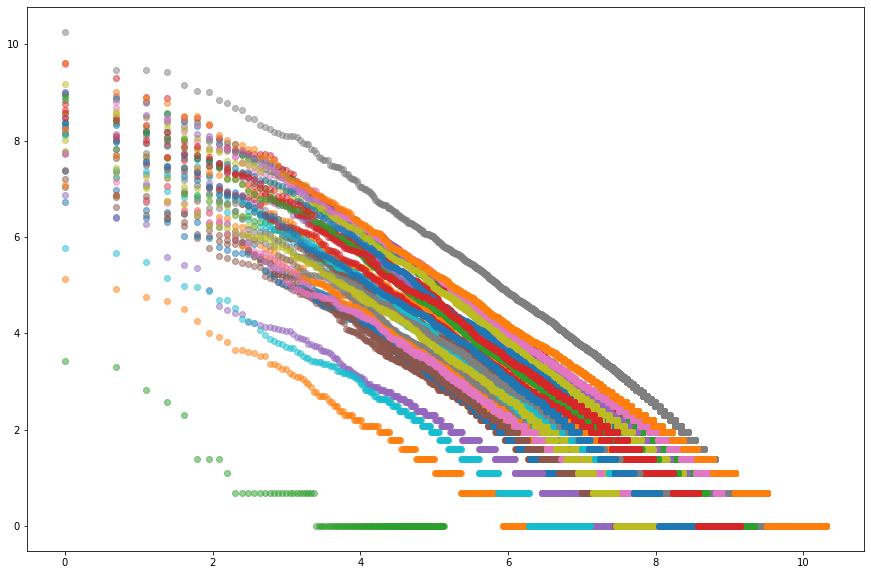

In [125]:
e_book_d = create_book_dictionary('english_books')
e_book_df = new_common_df(e_book_d)
new_slope(e_book_df, e_book_d)
e_book_df.head()
plot_df(e_book_df)

-1.0107121313967076 slope on 6564 unique words and 46940 total words for Abrégé_de_l'Histoire_Universelle_depuis_Charlemagne_jusques_à_Charlequint_Tome_by_Voltaire
-1.0821626223294891 slope on 6559 unique words and 60167 total words for Discours_de_la_méthode_by_René_Descartes
-1.0519955574492106 slope on 4205 unique words and 30567 total words for La_Radiologie_et_La_Guerre_by_Marie_Curie
-1.0862201937731193 slope on 11141 unique words and 118575 total words for Les_Historiettes_de_Tallemant_Tome_Gédéon_Tallemant_des_Réaux
-1.0386835989376182 slope on 12134 unique words and 104188 total words for Les_misérables_Tome_II_by_Victor_Hugo
-1.076538509431964 slope on 12230 unique words and 119679 total words for Les_misérables_Tome_I_by_Victor_Hugo
-1.1320610947426102 slope on 10337 unique words and 112573 total words for Le_tour_de_la_France_par_deux_enfants_by_G_Bruno
-1.1863147915701842 slope on 4156 unique words and 43771 total words for Recherches_sur_les_substances_radioactives_by_Mar

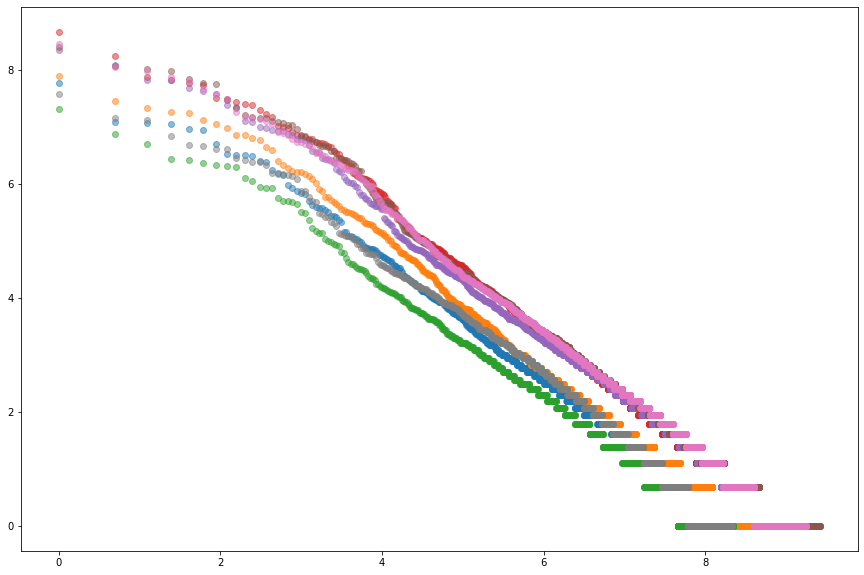

In [135]:
f_book_d = create_book_dictionary('french_books')
f_book_df = new_common_df(f_book_d)
new_slope(f_book_df, f_book_d)
plot_df(f_book_df)

-1.2797043772208996 slope on 13023 unique words and 195743 total words for The Iliad by Homer
-1.2936290659000396 slope on 7647 unique words and 130607 total words for The Odyssey by Homer


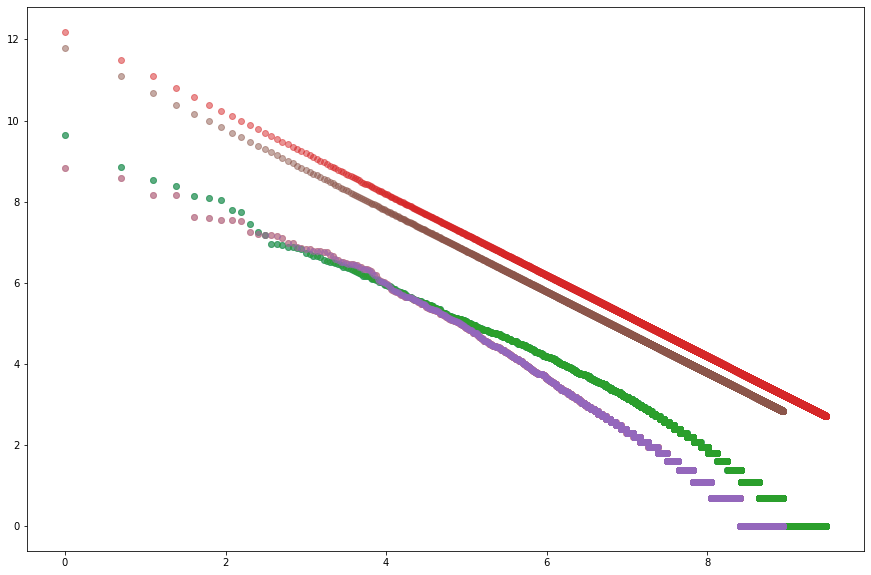

In [163]:
g_book_d = create_book_dictionary('greek_books')
g_book_df = new_common_df(g_book_d)
new_slope(g_book_df, g_book_d)
plot_df(g_book_df)
full_text = tokenize_dictionary(g_book_d)
expected_df = zipf_df(full_text,g_book_df)
plot_exp_df(g_book_df, expected_df)

-0.7534577641050947 slope on 4519 words for Ciceros_Orations_by_Cicero
-0.9154327731042071 slope on 4703 words for Meditationes_de_prima_philosophia_by_René_Descartes
-0.576680231674348 slope on 8276 words for Odes_and_Epodes_by_Horace
-0.8736204623553693 slope on 16637 words for The_Aeneid_by_Virgil


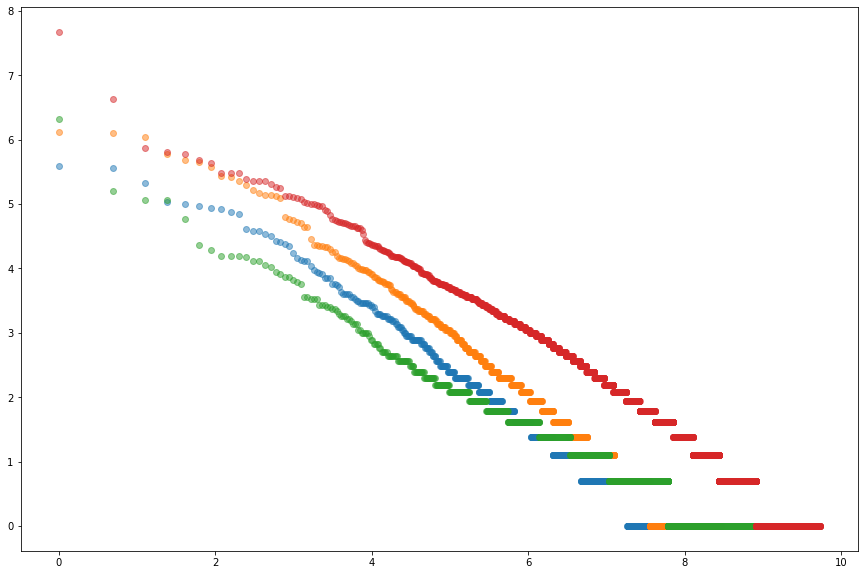

In [95]:
l_book_d = create_book_dictionary('latin_books')
l_book_df = new_common_df(l_book_d)
new_slope(l_book_df, l_book_d )
plot_df(l_book_df)

-0.900800643764066 slope on 3270 unique words and 16015 total words for Evangeline_by_Henry_Wadsworth_Longfellow
-1.1713774080823383 slope on 9417 unique words and 100285 total words for The_Aeneid_of_Virgil_English


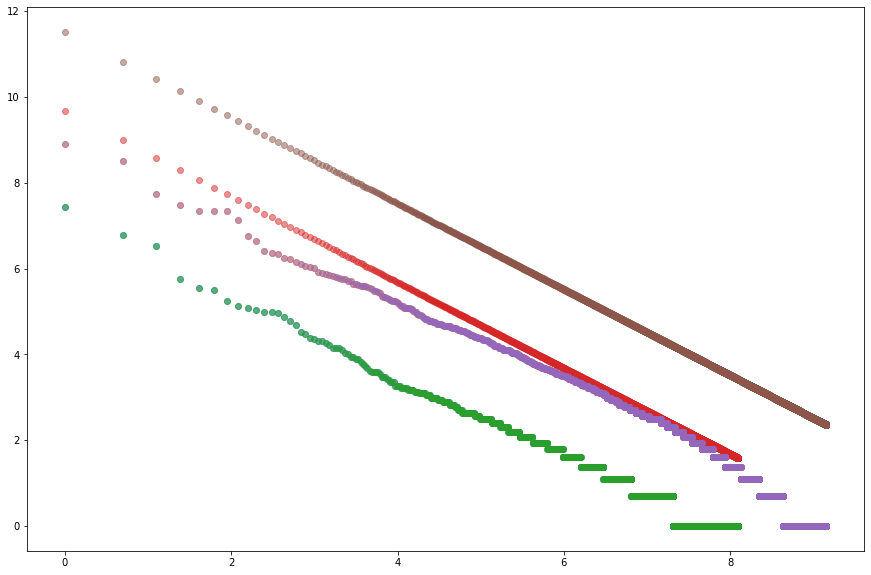

In [164]:
le_book_d = create_book_dictionary('latin_english_books')
le_book_df = new_common_df(le_book_d)
new_slope(le_book_df, le_book_d)
plot_df(le_book_df)
full_text = tokenize_dictionary(le_book_d)
expected_df = zipf_df(full_text,le_book_df)
plot_exp_df(le_book_df, expected_df)

The Cat in the Hat  By Dr. Seuss  The sun did not shine. It was too wet to play. So we sat in the house All that cold, cold, wet day.  I sat there with Sally. We sat there, we two. And I said, "How I wish We had something to do!"  Too wet to go out And too cold to play ball. So we sat in the house. We did nothing at all.  So all we could do was to  Sit! Sit! Sit! Sit!  And we did not like it. Not one little bit.  BUMP!  And then something went BUMP! How that bump made us jump!  We looked! Then we saw him step in on the mat! We looked! And we saw him! The Cat in the Hat! And he said to us, "Why do you sit there like that?" "I know it is wet And the sun is not sunny. But we can have Lots of good fun that is funny!"  "I know some good games we could play," Said the cat. "I know some new tricks," Said the Cat in the Hat. "A lot of good tricks. I will show them to you. Your mother Will not mind at all if I do."  Then Sally and I Did not know what to say. Our mother was out of the house For 

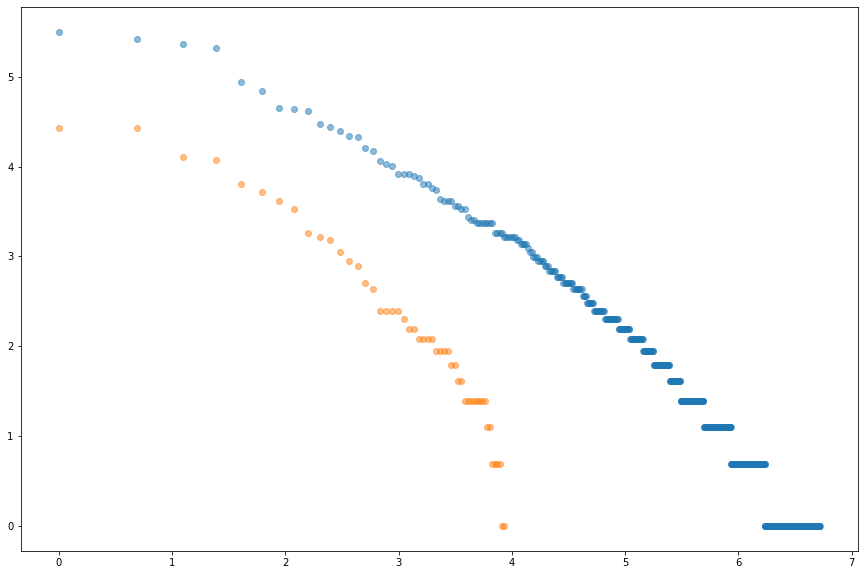

In [130]:
seuss_book_d = full_book_dictionary('seuss_books')
seuss_book_df = new_common_df(seuss_book_d)
new_slope(seuss_book_df, seuss_book_d)
plot_df(seuss_book_df)

In [140]:
seuss_dictionary = tokenize_dictionary(seuss_book_d)
seuss_dictionary

{'Cat_in_the_Hat_Dr_Seuss': ['The',
  'Cat',
  'in',
  'the',
  'Hat',
  'By',
  'Dr',
  'Seuss',
  'The',
  'sun',
  'did',
  'not',
  'shine',
  'It',
  'was',
  'too',
  'wet',
  'to',
  'play',
  'So',
  'we',
  'sat',
  'in',
  'the',
  'house',
  'All',
  'that',
  'cold',
  'cold',
  'wet',
  'day',
  'I',
  'sat',
  'there',
  'with',
  'Sally',
  'We',
  'sat',
  'there',
  'we',
  'two',
  'And',
  'I',
  'said',
  'How',
  'I',
  'wish',
  'We',
  'had',
  'something',
  'to',
  'do',
  'Too',
  'wet',
  'to',
  'go',
  'out',
  'And',
  'too',
  'cold',
  'to',
  'play',
  'ball',
  'So',
  'we',
  'sat',
  'in',
  'the',
  'house',
  'We',
  'did',
  'nothing',
  'at',
  'all',
  'So',
  'all',
  'we',
  'could',
  'do',
  'was',
  'to',
  'Sit',
  'Sit',
  'Sit',
  'Sit',
  'And',
  'we',
  'did',
  'not',
  'like',
  'it',
  'Not',
  'one',
  'little',
  'bit',
  'BUMP',
  'And',
  'then',
  'something',
  'went',
  'BUMP',
  'How',
  'that',
  'bump',
  'made',
  'us',


In [25]:
manuscript_book_d = full_book_dictionary('manuscript_text')
manuscript_df = full_common_df(200, manuscript_book_d)
pfit_slope(manuscript_df)
manuscript_df.head()

voynich_script
[('8am', 969), ('tc8g', 498), ('oe', 439), ('4odam', 431), ('sc8g', 426), ('am', 404), ('toe', 393), ('s', 374), ('tcg', 342), ('currier', 324), ('m', 322), ('a', 320), ('4odcc8g', 302), ('8ar', 297), ('or', 293), ('4odccg', 281), ('ar', 279), ('odam', 276), ('scg', 273), ('4odc8g', 267), ('n', 258), ('2', 257), ('8ae', 257), ('hand', 236), ('8g', 235), ('2am', 225), ('o', 221), ('tor', 213), ('line', 209), ('ends', 207), ('folio', 206), ('page', 205), ('oham', 195), ('language', 193), ('ae', 193), ('4odae', 188), ('soe', 183), ('g', 176), ('r', 174), ('4oe', 170), ('tccg', 165), ('tcoe', 157), ('odccg', 148), ('4odar', 145), ('tg', 143), ('4odg', 143), ('t8g', 142), ('tdzg', 138), ('transcription', 135), ('ohc8g', 135), ('from', 133), ('sccg', 132), ('added', 131), ('dam', 130), ('ohae', 128), ('c', 128), ('odae', 127), ('herbal', 124), ('ohar', 124), ('so', 120), ('4oham', 120), ('ram', 119), ('hzg', 115), ('etc8g', 115), ('odar', 113), ('4odcg', 109), ('odc8g', 108), 

,1,2,3,4,5,6,7,8,9,10,...,191,192,193,194,195,196,197,198,199,200
0,0.0,0.693147,1.098612,1.386294,1.609438,1.791759,1.94591,2.079442,2.197225,2.302585,...,5.252273,5.257495,5.26269,5.267858,5.273,5.278115,5.283204,5.288267,5.293305,5.298317
1,6.876265,6.2106,6.084499,6.066108,6.054439,6.001415,5.97381,5.834811,5.780744,5.774552,...,3.496508,3.496508,3.496508,3.465736,3.465736,3.465736,3.433987,3.433987,3.433987,3.433987


In [27]:
plt.rcParams["figure.figsize"] = [20, 15]
count = 0
for row in word_df.iterrows():
    if count != 0:
        plt.plot(word_df.loc[0,:], word_df.loc[count,:], alpha=.5, linewidth='4')
    count = count + 1

In [28]:
count = 0

for b in book_word_d:
    if count < 10:
        print(b)
        count = count + 1
        false_word = ['s','t','n']
        ind = []
        fre = []
        fretwo = []
        run = 1
        book_token_words = [x.lower() for x in regexp_tokenize(book_word_d[b], '\w+')]
        book_token_counter = Counter(book_token_words).most_common(100)
        for item in book_token_counter:
            if item[0] not in false_word:
                ind.append(item[0])
                fre.append(item[1])
                fretwo.append(item[1]*run)
                run = run + 1
        plt.bar(ind, fretwo, alpha =  .75)
        plt.xticks(rotation='vertical')
        plt.show()